# Práctica Audio Jorge Rivera y Rodrigo López de Toledo

### En esta práctica se ha hecho un clasificador de diferentes sonidos ambientales. El dataset tiene 1440 audios diferentes. 

### Las diferentes clases son: rain, sea_waves, crackling_fire, crickets, chirping_birds, water_drops, wind, pouring_water, toilet_flush, thunderstorm, airplane, church_bells, dog, rooster, crow, cow, pig, sheep, cat, hen, frog.

### Se puede entrenar tanto con el .csv como con los .npy, que es el mismo dataset ya procesado y guardado en formato NumPy. Simplemente hay que poner **load_kaggle_data = False** y **load_numpy = True** y descomentar **load_numpy = "kaggle50.npy"** (Es mucho mas rápido)

### El dataset usado es el siguiente: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Colab Notebooks/AUDIO/audio-classifier

/content/drive/MyDrive/Colab Notebooks/AUDIO/audio-classifier


In [ ]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import re
import os
import random
from datetime import datetime

import librosa
from scipy.io import wavfile
import numpy as np
import pandas as pd
import sklearn as sk
import torch
from torch.utils import data
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from sklearn import model_selection
from sklearn.metrics import confusion_matrix

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
# Configs for Machine Learning
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Loading Test/Training Data 
load_kaggle_data = True
# Data Source: https://www.kaggle.com/mmoreaux/environmental-sound-classification-50#esc50.csv

# Loading/Saving Model
save_numpy = False
load_numpy = False
# save_numpy = "kaggle50.npy"
# load_numpy = "kaggle50.npy"

load_model_file = False
save_model_file = False

# Training / Fitting / Optimizing Model
test_size = 0.2
epochs    = 250
batch_size= 50
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

do_model_analysis = False

### Extracción de características: se han extraído muchas de las features vistas en clase, tanto en el dominio del tiempo como de la frecuencia

In [ ]:
def extract_features(file_name):

    features = []
    
    audio_data, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(audio_data))
    
    mfcc = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T,axis=0)
    features.extend(mfcc)
    
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    features.extend(chroma)
    
    mel = np.mean(librosa.feature.melspectrogram(audio_data, sr=sample_rate).T,axis=0)
    features.extend(mel)
    
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    features.extend(contrast)

    spec_cent = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate).T, axis=0)
    features.extend(spec_cent)

    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=audio_data, sr=sample_rate).T, axis=0)
    features.extend(spec_bw)

    rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_data, sr=sample_rate).T, axis=0)
    features.extend(rolloff)

    zcr = np.mean(librosa.feature.zero_crossing_rate(audio_data).T, axis=0)
    features.extend(zcr)

    return np.array(features)

In [ ]:
def display_wav(file = None):
    if not file:
        print("No wav file to display")
        return
    librosa_load, librosa_sampling_rate = librosa.load(file)
    scipy_sampling_rate, scipy_load = wavfile.read(file)
    print('original sample rate:',scipy_sampling_rate)
    print('converted sample rate:',librosa_sampling_rate)
    print('\n')
    plt.figure(figsize=(12, 4))
    plt.plot(librosa_load)

In [ ]:
def load_all_wav_files(load_kaggle=True):
    one_file = None
    all_data = []
    all_labels = []
    if load_kaggle:
        print("Loading Kaggle")
        metadata = pd.read_csv("data/environmental_sounds/esc50.csv")
        for root, dirs, files in os.walk("data/environmental_sounds/audio/audio/"):
            for file in files:
                if file.endswith('.wav'):
                    fname = os.path.join(root, file)
                    try:
                      label = metadata[metadata.filename == file]["category"].tolist()[0]
                    except:
                      pass
                    classes=["rain", "sea_waves", "crackling_fire", "crickets", "chirping_birds", "water_drops", "wind", "pouring_water", "toilet_flush", "thunderstorm", "airplane", "church_bells", "dog", "rooster", "crow", "cow", "pig", "sheep", "cat", "hen", "frog"] # Clases que se van a clasificar
                    if label in classes:
                        if(len(all_data) % 100 == 0):
                            print(str(len(all_data)))
                        features = extract_features(fname)
                        all_data.append(features)
                        all_labels.append(label)

    return np.array(all_data), np.array(all_labels), one_file

In [ ]:
def analyze_features(all_data, all_labels):
    #seeking only the numeric features from the data
    numeric_features = all_data.select_dtypes(include = [np.number])
    print(numeric_features.dtypes)
    corr = numeric_features.corr()
    print(corr)

In [ ]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes,
           yticklabels=classes,
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(len(classes)-0.5, -0.5)
    ax.set_aspect('auto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.show()

In [ ]:
all_data = np.array([])
all_labels = np.array([])
one_file = "data/environmental_sounds/audio/audio/1-137-A-32.wav"
if not load_numpy:
    all_data, all_labels, one_file = load_all_wav_files(load_kaggle_data)
else:
    all_data = np.load("data/all_data_"+load_numpy)
    all_labels = np.load("data/all_labels_"+load_numpy)
    
if save_numpy:
    np.save("data/all_data_"+save_numpy, all_data)
    np.save("data/all_labels_"+save_numpy, all_labels)
display_wav(one_file)

Loading Kaggle
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
No wav file to display


In [ ]:
classes = list(set(all_labels))
n_classes = len(classes)
numeric_labels = np.array([classes.index(label) for label in all_labels])
print("Clases a clasificar: {}".format(classes))

Clases a clasificar: ['dog', 'rain', 'rooster', 'cow', 'toilet_flush', 'church_bells', 'thunderstorm', 'hen', 'chirping_birds', 'pouring_water', 'crickets', 'pig', 'airplane', 'sheep', 'sea_waves', 'crow', 'cat', 'water_drops', 'frog', 'crackling_fire', 'wind']


In [ ]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(all_data, numeric_labels, test_size=test_size, shuffle=True)
print("Shape of Train Data: {}, {}".format(x_train.shape, y_train.shape))
print("Shape of Test Data: {}, {}".format(x_test.shape, y_test.shape))

Shape of Train Data: (2017, 191), (2017,)
Shape of Test Data: (505, 191), (505,)


### Ahora se definen los tres modelos que se van a probar para realizar la clasificación

### Modelo 1

In [ ]:
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_dim=x_train.shape[1]))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dense(n_classes, activation='softmax')) # softmax

model_1.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Modelo 2

In [ ]:
model_2 = Sequential()
model_2.add(Dense(16, activation='relu', input_dim=x_train.shape[1]))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.3))
model_2.add(Dense(32, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(64, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.3))
model_2.add(Dense(32, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.3))
model_2.add(Dense(16, activation='relu'))
model_2.add(BatchNormalization())
model_2.add(Dense(n_classes, activation='sigmoid')) # sigmoid

model_2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Modelo 3

In [ ]:
model_3 = Sequential()
model_3.add(Dense(64, input_dim=x_train.shape[1]))
model_3.add(Dropout(0.3))
model_3.add(LeakyReLU())
model_3.add(Dense(32))
model_3.add(LeakyReLU())
model_3.add(Dropout(0.3))
model_3.add(Dense(16))
model_3.add(LeakyReLU())
model_3.add(Dense(n_classes, activation='softmax')) # softmax

model_3.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Se entrena el modelo 1

In [ ]:
history_1 = None
if load_model_file:
    fpath = os.path.join("model", load_model_file + ".hdf5")
    model_1.load_weights(fpath)
elif save_model_file:
    fpath = os.path.join("model", save_model_file + ".hdf5")
    checkpointer = ModelCheckpoint(filepath=fpath,
                                   monitor='val_loss', 
                                   save_best_only=True,
                                   verbose=1)
    history_1 = model_1.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpointer],
#                        shuffle=True,
                        verbose=2)
else:
    history_1 = model_1.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
#                        shuffle=True,
                        verbose=2)

Epoch 1/250
41/41 - 2s - loss: 93.0863 - accuracy: 0.0506 - val_loss: 5.6933 - val_accuracy: 0.0673
Epoch 2/250
41/41 - 0s - loss: 3.7225 - accuracy: 0.0416 - val_loss: 3.3864 - val_accuracy: 0.0594
Epoch 3/250
41/41 - 0s - loss: 3.1218 - accuracy: 0.0580 - val_loss: 3.0091 - val_accuracy: 0.0693
Epoch 4/250
41/41 - 0s - loss: 3.0058 - accuracy: 0.0625 - val_loss: 2.9674 - val_accuracy: 0.0693
Epoch 5/250
41/41 - 0s - loss: 2.9700 - accuracy: 0.0605 - val_loss: 2.9438 - val_accuracy: 0.0713
Epoch 6/250
41/41 - 0s - loss: 2.9602 - accuracy: 0.0694 - val_loss: 2.9227 - val_accuracy: 0.0733
Epoch 7/250
41/41 - 0s - loss: 2.9456 - accuracy: 0.0709 - val_loss: 2.9090 - val_accuracy: 0.0792
Epoch 8/250
41/41 - 0s - loss: 2.9366 - accuracy: 0.0749 - val_loss: 2.9101 - val_accuracy: 0.0812
Epoch 9/250
41/41 - 0s - loss: 2.9283 - accuracy: 0.0768 - val_loss: 2.9021 - val_accuracy: 0.0891
Epoch 10/250
41/41 - 0s - loss: 2.9073 - accuracy: 0.0838 - val_loss: 2.8816 - val_accuracy: 0.1010
Epoch 11

### Se entrena el modelo 2

In [ ]:
history_2 = None
if load_model_file:
    fpath = os.path.join("model", load_model_file + ".hdf5")
    model_2.load_weights(fpath)
elif save_model_file:
    fpath = os.path.join("model", save_model_file + ".hdf5")
    checkpointer = ModelCheckpoint(filepath=fpath,
                                   monitor='val_loss', 
                                   save_best_only=True,
                                   verbose=1)
    history_2 = model_2.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpointer],
#                        shuffle=True,
                        verbose=2)
else:
    history_2 = model_2.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
#                        shuffle=True,
                        verbose=2)

Epoch 1/250
41/41 - 2s - loss: 2.9410 - accuracy: 0.1026 - val_loss: 3.6493 - val_accuracy: 0.0733
Epoch 2/250
41/41 - 0s - loss: 2.6956 - accuracy: 0.1418 - val_loss: 2.7642 - val_accuracy: 0.1248
Epoch 3/250
41/41 - 0s - loss: 2.6045 - accuracy: 0.1577 - val_loss: 2.5707 - val_accuracy: 0.2079
Epoch 4/250
41/41 - 0s - loss: 2.5228 - accuracy: 0.1820 - val_loss: 2.5755 - val_accuracy: 0.1663
Epoch 5/250
41/41 - 0s - loss: 2.4786 - accuracy: 0.1899 - val_loss: 2.4688 - val_accuracy: 0.2139
Epoch 6/250
41/41 - 0s - loss: 2.4104 - accuracy: 0.2013 - val_loss: 2.4294 - val_accuracy: 0.2040
Epoch 7/250
41/41 - 0s - loss: 2.3461 - accuracy: 0.2330 - val_loss: 2.3534 - val_accuracy: 0.2416
Epoch 8/250
41/41 - 0s - loss: 2.3417 - accuracy: 0.2330 - val_loss: 2.3049 - val_accuracy: 0.2713
Epoch 9/250
41/41 - 0s - loss: 2.3149 - accuracy: 0.2444 - val_loss: 2.1986 - val_accuracy: 0.3149
Epoch 10/250
41/41 - 0s - loss: 2.2846 - accuracy: 0.2489 - val_loss: 2.1544 - val_accuracy: 0.2970
Epoch 11/

### Se entrena el modelo 3

In [ ]:
history_3 = None
if load_model_file:
    fpath = os.path.join("model", load_model_file + ".hdf5")
    model_3.load_weights(fpath)
elif save_model_file:
    fpath = os.path.join("model", save_model_file + ".hdf5")
    checkpointer = ModelCheckpoint(filepath=fpath,
                                   monitor='val_loss', 
                                   save_best_only=True,
                                   verbose=1)
    history_3= model_3.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpointer],
#                        shuffle=True,
                        verbose=2)
else:
    history_3 = model_3.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_test, y_test),
#                        shuffle=True,
                        verbose=2)

Epoch 1/250
41/41 - 1s - loss: 94.4981 - accuracy: 0.0610 - val_loss: 5.9564 - val_accuracy: 0.1604
Epoch 2/250
41/41 - 0s - loss: 10.6260 - accuracy: 0.1190 - val_loss: 3.5417 - val_accuracy: 0.2257
Epoch 3/250
41/41 - 0s - loss: 6.3511 - accuracy: 0.1413 - val_loss: 2.7511 - val_accuracy: 0.2792
Epoch 4/250
41/41 - 0s - loss: 4.9024 - accuracy: 0.1552 - val_loss: 2.5192 - val_accuracy: 0.2891
Epoch 5/250
41/41 - 0s - loss: 4.1967 - accuracy: 0.1696 - val_loss: 2.3911 - val_accuracy: 0.2931
Epoch 6/250
41/41 - 0s - loss: 3.9326 - accuracy: 0.1765 - val_loss: 2.2244 - val_accuracy: 0.3386
Epoch 7/250
41/41 - 0s - loss: 3.3539 - accuracy: 0.1983 - val_loss: 2.2410 - val_accuracy: 0.3386
Epoch 8/250
41/41 - 0s - loss: 3.3410 - accuracy: 0.2018 - val_loss: 2.1970 - val_accuracy: 0.3545
Epoch 9/250
41/41 - 0s - loss: 3.1221 - accuracy: 0.2291 - val_loss: 2.1519 - val_accuracy: 0.3921
Epoch 10/250
41/41 - 0s - loss: 3.0604 - accuracy: 0.2162 - val_loss: 2.1243 - val_accuracy: 0.3980
Epoch 1

### Se muestra la arquitectura de cada uno de los modelos

In [ ]:
print("\nSummary del Modelo 1\n")
model_1.summary()
print("\nSummary del Modelo 2\n")
model_2.summary()
print("\nSummary del Modelo 3\n")
model_3.summary()


Summary del Modelo 1

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                12288     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 21)                357       
Total params: 15,253
Trainable params: 15,253
Non-trainable params: 0
_________________________________________________________________

Summary del Modelo 2

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)           

### Comparativa de los resultados obtenidos con cada uno de los  modelos

In [ ]:
score_train = model_1.evaluate(x_train, y_train, verbose=0)
print("\nTraining Accuracy for model 1: ", score_train[1])
print("Loss for model 1: %.2f" % score_train[0])

score_test = model_1.evaluate(x_test, y_test, verbose=0)
print("\nTesting Accuracy for model 1: ", score_test[1])
print("Loss for model 1: %.2f" % score_test[0])
print("\n===================================================")

score_train = model_2.evaluate(x_train, y_train, verbose=0)
print("\nTraining Accuracy for model 2: ", score_train[1])
print("Loss for model 2: %.2f" % score_train[0])

score_test = model_2.evaluate(x_test, y_test, verbose=0)
print("\nTesting Accuracy for model 2: ", score_test[1])
print("Loss for model 2: %.2f" % score_test[0])
print("\n===================================================")


score_train = model_3.evaluate(x_train, y_train, verbose=0)
print("\nTraining Accuracy for model 3: ", score_train[1])
print("Loss for model 3: %.2f" % score_train[0])

score_test = model_3.evaluate(x_test, y_test, verbose=0)
print("\nTesting Accuracy for model 3: ", score_test[1])
print("Loss for model 3: %.2f" % score_test[0])
print("\n===================================================")


Training Accuracy for model 1:  0.6757560968399048
Loss for model 1: 0.97

Testing Accuracy for model 1:  0.6198019981384277
Loss for model 1: 1.41


Training Accuracy for model 2:  0.6117997169494629
Loss for model 2: 1.09

Testing Accuracy for model 2:  0.5584158301353455
Loss for model 2: 1.27


Training Accuracy for model 3:  0.8874565958976746
Loss for model 3: 0.38

Testing Accuracy for model 3:  0.8138613700866699
Loss for model 3: 0.72



### Se muestran las matrices de confusión de cada modelo

In [ ]:
y_pred_percentages_1 = model_1.predict(x_test)

y_pred_1 = np.argmax(y_pred_percentages_1, axis=1)

cm_1 = confusion_matrix(y_test, y_pred_1)

y_pred_percentages_2 = model_2.predict(x_test)

y_pred_2 = np.argmax(y_pred_percentages_2, axis=1)

cm_2 = confusion_matrix(y_test, y_pred_2)

y_pred_percentages_3 = model_3.predict(x_test)

y_pred_3 = np.argmax(y_pred_percentages_3, axis=1)

cm_3 = confusion_matrix(y_test, y_pred_3)


Matriz de Confusion del Modelo 1



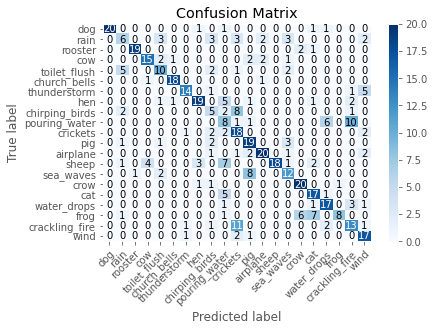


Matriz de Confusion del Modelo 2



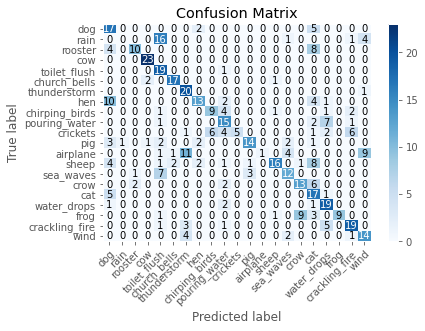


Matriz de Confusion del Modelo 2



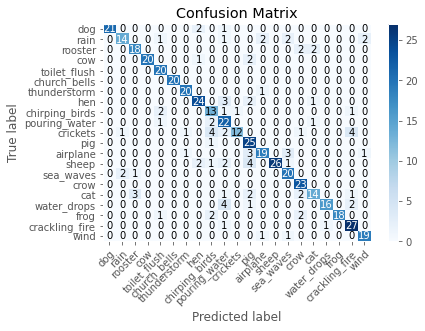

In [ ]:
print("\nMatriz de Confusion del Modelo 1\n")
plot_confusion_matrix(cm_1)
print("\nMatriz de Confusion del Modelo 2\n")
plot_confusion_matrix(cm_2)
print("\nMatriz de Confusion del Modelo 2\n")
plot_confusion_matrix(cm_3)

#### El modelo 1 hace mal la clasificación de crackling fire, lo clasifica como crickets hasta en 11 veces. También falla bastante, 10 veces, a la hora de clasificar pouring water que lo clasifica como crackling fire.

#### El modelo 2 donde más falla es a la hora de clasificar rain, hasta 16 veces falla, lo clasifica como toilet flush.

#### El modelo 3 cuando más falla es cuando clasifica las clases de crickets, water drops y sheep, las clasifica como chriping birds, pouring water y pig respectivamente. La clase de crickets también la clasifica como crackling fire 4 veces.

### Accuracy obtenida

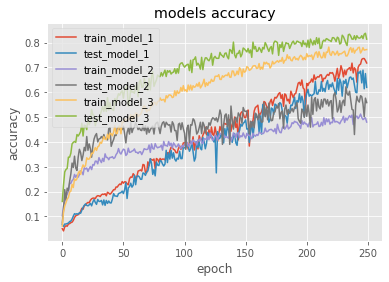

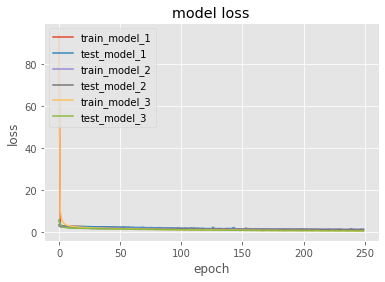

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('models accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_model_1', 'test_model_1', 'train_model_2', 'test_model_2','train_model_3', 'test_model_3'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_model_1', 'test_model_1', 'train_model_2', 'test_model_2','train_model_3', 'test_model_3'], loc='upper left')
plt.show()

### Se puede comprobar que con el modelo 3 es con el que se obtienen los mejores resultados, mientras que con el modelo 2, se obtienen los peores.